In [1]:
import pickle
import helpsk as hlp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder  # , LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
# from sklearn.base import BaseEstimator, TransformerMixin

%matplotlib inline

# Load Data

In [2]:
parser = hlp.sklearn_eval.SearchCVParser.from_yaml_file(yaml_file_name = 'Run 1 - XGBoost - BayesSearchCV.yaml')
parser.best_primary_score_params

{'colsample_bytree': 0.1049484964611341,
 'learning_rate': 0.013882012240590661,
 'max_depth': 5,
 'n_estimators': 843,
 'subsample': 0.8790046279648855,
 'encoder': 'CustomOrdinalEncoder()',
 'imputer': 'SimpleImputer()',
 'scaler': 'MinMaxScaler()'}

In [3]:
with open('../X_train.pkl', 'rb') as handle:
    X_train = pickle.load(handle)
    print(X_train.shape)

with open('../y_train.pkl', 'rb') as handle:
    y_train = pickle.load(handle)
    print(len(y_train))

with open('../X_test.pkl', 'rb') as handle:
    X_test = pickle.load(handle)
    print(X_test.shape)

with open('../y_test.pkl', 'rb') as handle:
    y_test = pickle.load(handle)
    print(len(y_test))

(800, 20)
800
(200, 20)
200


In [4]:
X_train.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
29,NaN,NaN,delayed previously,business,0.0,<100,>=7,3.0,male single,none,4.0,no known property,63.0,none,own,2.0,skilled,1.0,yes,yes
535,>=200,21.0,critical/other existing credit,education,2319.0,<100,<1,2.0,male div/sep,none,1.0,car,33.0,none,rent,1.0,skilled,1.0,none,yes
695,no checking,6.0,existing paid,used car,1236.0,500<=X<1000,1<=X<4,2.0,male single,none,4.0,life insurance,50.0,none,rent,1.0,skilled,1.0,none,yes
557,no checking,21.0,no credits/all paid,new car,5003.0,no known savings,1<=X<4,1.0,female div/dep/mar,none,4.0,life insurance,29.0,bank,own,2.0,skilled,1.0,yes,yes
836,no checking,12.0,existing paid,radio/tv,886.0,no known savings,1<=X<4,4.0,female div/dep/mar,none,2.0,car,21.0,none,own,1.0,skilled,1.0,none,yes


In [5]:
y_train[0:10]

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 1])

In [6]:
X_test.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
521,<0,18.0,existing paid,radio/tv,3190.0,<100,1<=X<4,2.0,female div/dep/mar,none,2.0,real estate,24.0,none,own,1.0,skilled,1.0,none,yes
737,<0,18.0,existing paid,new car,4380.0,100<=X<500,1<=X<4,3.0,male single,none,4.0,car,35.0,none,own,1.0,unskilled resident,2.0,yes,yes
740,<0,24.0,all paid,new car,2325.0,100<=X<500,4<=X<7,2.0,male single,none,3.0,car,32.0,bank,own,1.0,skilled,1.0,none,yes
660,>=200,12.0,existing paid,radio/tv,1297.0,<100,1<=X<4,3.0,male mar/wid,none,4.0,real estate,23.0,none,rent,1.0,skilled,1.0,none,yes
411,no checking,33.0,critical/other existing credit,used car,7253.0,<100,4<=X<7,3.0,male single,none,2.0,car,35.0,none,own,2.0,high qualif/self emp/mgmt,1.0,yes,yes


In [7]:
y_test[0:10]

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

# Training and Test Data

In [8]:
y_train[0:10]

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 1])

In [14]:
numeric_columns = hlp.pandas.get_numeric_columns(X_train)
non_numeric_columns = hlp.pandas.get_non_numeric_columns(X_train)
print(numeric_columns)
print(non_numeric_columns)

['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']
['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker']


In [15]:
parser.best_primary_score_params

{'colsample_bytree': 0.1049484964611341,
 'learning_rate': 0.013882012240590661,
 'max_depth': 5,
 'n_estimators': 843,
 'subsample': 0.8790046279648855,
 'encoder': 'CustomOrdinalEncoder()',
 'imputer': 'SimpleImputer()',
 'scaler': 'MinMaxScaler()'}

In [16]:
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler()),
])

In [17]:
non_numeric_pipeline = Pipeline([
    ('encoder', hlp.sklearn_pipeline.CustomOrdinalEncoder()),
])

In [18]:
from sklearn.compose import ColumnTransformer
transformations_pipeline = ColumnTransformer([
    ('numeric', numeric_pipeline, numeric_columns),
    ('non_numeric', non_numeric_pipeline, non_numeric_columns)
])

# Model

In [24]:
from xgboost import XGBClassifier
random_forest_model = XGBClassifier(
    colsample_bytree=0.1049484964611341,
    learning_rate=0.013882012240590661,
    max_depth=5,
    n_estimators=843,
    subsample=0.8790046279648855,
    random_state=42,
    use_label_encoder=False,
)

In [25]:
full_pipeline = Pipeline([
    ('prep', transformations_pipeline),
    ('model', random_forest_model)
])

In [26]:
# Show the levels of pipelines/transformers/model
full_pipeline.named_steps

{'prep': ColumnTransformer(transformers=[('numeric',
                                  Pipeline(steps=[('imputer', SimpleImputer()),
                                                  ('scaler', MinMaxScaler())]),
                                  ['duration', 'credit_amount',
                                   'installment_commitment', 'residence_since',
                                   'age', 'existing_credits',
                                   'num_dependents']),
                                 ('non_numeric',
                                  Pipeline(steps=[('encoder',
                                                   CustomOrdinalEncoder())]),
                                  ['checking_status', 'credit_history',
                                   'purpose', 'savings_status', 'employment',
                                   'personal_status', 'other_parties',
                                   'property_magnitude', 'other_payment_plans',
                                   '

In [28]:
fitted_pipeline = full_pipeline.fit(X_train, y_train)

[14:07:37] WARNING: /private/var/folders/7x/wc3jx_91337bggbzk01kpvs40000gn/T/pip-install-9asvcns4/xgboost_6cd18ae4d2a4469e8f54a1f945448b8a/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [29]:
fitted_pipeline.predict(X_test)

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 1])

In [30]:
fitted_pipeline.predict_proba(X_test)

array([[0.3033579 , 0.6966421 ],
       [0.49178302, 0.508217  ],
       [0.63111186, 0.36888814],
       [0.31892526, 0.68107474],
       [0.09109342, 0.9089066 ],
       [0.3190269 , 0.6809731 ],
       [0.09450716, 0.90549284],
       [0.46342027, 0.5365797 ],
       [0.06658894, 0.93341106],
       [0.10118395, 0.89881605],
       [0.11620831, 0.8837917 ],
       [0.44247717, 0.55752283],
       [0.15185833, 0.8481417 ],
       [0.4746039 , 0.5253961 ],
       [0.6371982 , 0.36280182],
       [0.48865122, 0.5113488 ],
       [0.11916411, 0.8808359 ],
       [0.15178114, 0.84821886],
       [0.45000905, 0.54999095],
       [0.13180804, 0.86819196],
       [0.14308423, 0.8569158 ],
       [0.37285525, 0.62714475],
       [0.12456447, 0.87543553],
       [0.02916753, 0.97083247],
       [0.0662595 , 0.9337405 ],
       [0.45864874, 0.54135126],
       [0.47914314, 0.52085686],
       [0.49469066, 0.50530934],
       [0.17079753, 0.8292025 ],
       [0.16941756, 0.83058244],
       [0.

In [31]:
y_test

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 1])

## Training Set Evaluation

Understand the nature/degree of model overfitting by comparing to `Test Set Evaluation`

In [56]:
predicted_scores = fitted_pipeline.predict_proba(X_train)[:, 1]

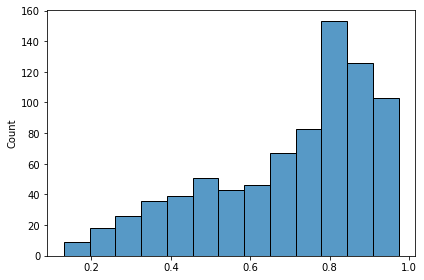

In [57]:
sns.histplot(predicted_scores)
plt.tight_layout()

In [58]:
evaluator = hlp.sklearn_eval.TwoClassEvaluator(
    actual_values=y_train,
    predicted_scores=predicted_scores,
    labels=('Bad', 'Good'),
    score_threshold=0.5
)

In [59]:
evaluator.all_metrics_df(return_style=True, round_by=3)

,Scores,Details
AUC,0.933,Area under the ROC curve (true pos. rate vs false pos. rate); ranges from 0.5 (purely random classifier) to 1.0 (perfect classifier)
True Positive Rate,0.970,"97.0% of positive instances were correctly identified.; i.e. 542 ""Good"" labels were correctly identified out of 559 instances; a.k.a Sensitivity/Recall"
True Negative Rate,0.589,"58.9% of negative instances were correctly identified.; i.e. 142 ""Bad"" labels were correctly identified out of 241 instances"
False Positive Rate,0.411,"41.1% of negative instances were incorrectly identified as positive; i.e. 99 ""Bad"" labels were incorrectly identified as ""Good"", out of 241 instances"
False Negative Rate,0.030,"3.0% of positive instances were incorrectly identified as negative; i.e. 17 ""Good"" labels were incorrectly identified as ""Bad"", out of 559 instances"
Positive Predictive Value,0.846,"When the model claims an instance is positive, it is correct 84.6% of the time; i.e. out of the 641 times the model predicted ""Good"", it was correct 542 times; a.k.a precision"
Negative Predictive Value,0.893,"When the model claims an instance is negative, it is correct 89.3% of the time; i.e. out of the 159 times the model predicted ""Bad"", it was correct 142 times"
F1 Score,0.903,"The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0."
Accuracy,0.855,85.5% of instances were correctly identified
Error Rate,0.145,14.5% of instances were incorrectly identified


In [60]:
del predicted_scores

## Test Set Evaluation

In [61]:
predicted_scores = fitted_pipeline.predict_proba(X_test)[:, 1]

In [62]:
predicted_scores[0:10]

array([0.6966421 , 0.508217  , 0.36888814, 0.68107474, 0.9089066 ,
       0.6809731 , 0.90549284, 0.5365797 , 0.93341106, 0.89881605],
      dtype=float32)

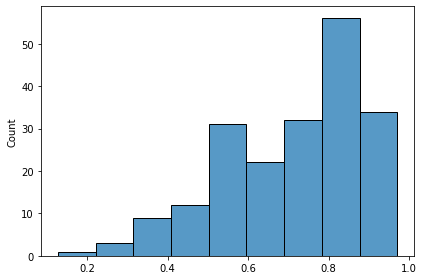

In [63]:
sns.histplot(predicted_scores)
plt.tight_layout()

In [64]:
y_test_cat = pd.Series(y_test).replace({1: 'Defaulted', 0: 'Not Defaulted'})
y_test_cat.head()

0    Not Defaulted
1        Defaulted
2        Defaulted
3        Defaulted
4        Defaulted
dtype: object

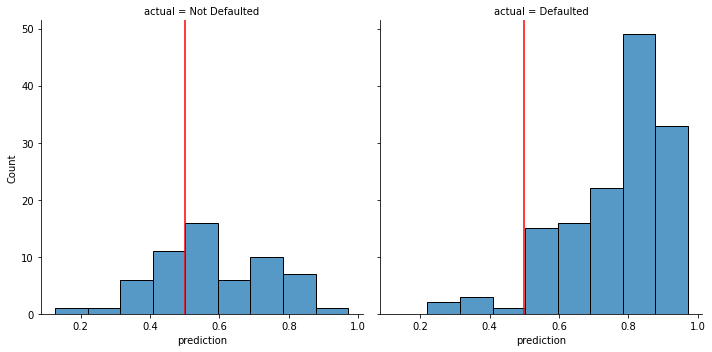

In [65]:
axes = sns.displot(
    pd.DataFrame({
        'prediction': predicted_scores,
        'actual': y_test_cat
    }),
    x='prediction',
    col='actual'
)
for axis in axes.axes.flat:
    axis.axvline(x=0.5, ymin=0, ymax=100, color='red')
plt.tight_layout()

In [66]:
del y_test_cat
del axes

In [67]:
evaluator = hlp.sklearn_eval.TwoClassEvaluator(
    actual_values=y_test,
    predicted_scores=predicted_scores,
    labels=('Bad', 'Good'),
    score_threshold=0.5
)

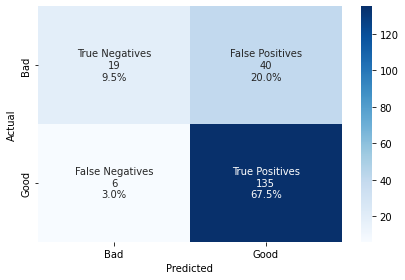

In [68]:
evaluator.plot_confusion_matrix()

In [69]:
evaluator.all_metrics_df(return_style=True, round_by=3)

,Scores,Details
AUC,0.814,Area under the ROC curve (true pos. rate vs false pos. rate); ranges from 0.5 (purely random classifier) to 1.0 (perfect classifier)
True Positive Rate,0.957,"95.7% of positive instances were correctly identified.; i.e. 135 ""Good"" labels were correctly identified out of 141 instances; a.k.a Sensitivity/Recall"
True Negative Rate,0.322,"32.2% of negative instances were correctly identified.; i.e. 19 ""Bad"" labels were correctly identified out of 59 instances"
False Positive Rate,0.678,"67.8% of negative instances were incorrectly identified as positive; i.e. 40 ""Bad"" labels were incorrectly identified as ""Good"", out of 59 instances"
False Negative Rate,0.043,"4.3% of positive instances were incorrectly identified as negative; i.e. 6 ""Good"" labels were incorrectly identified as ""Bad"", out of 141 instances"
Positive Predictive Value,0.771,"When the model claims an instance is positive, it is correct 77.1% of the time; i.e. out of the 175 times the model predicted ""Good"", it was correct 135 times; a.k.a precision"
Negative Predictive Value,0.760,"When the model claims an instance is negative, it is correct 76.0% of the time; i.e. out of the 25 times the model predicted ""Bad"", it was correct 19 times"
F1 Score,0.854,"The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0."
Accuracy,0.770,77.0% of instances were correctly identified
Error Rate,0.230,23.0% of instances were incorrectly identified


Compare results against scores if we predicted all `Good`

In [70]:
dummy_predicted_scores = np.array([0.99] * len(predicted_scores))

In [71]:
dummy_eval = hlp.sklearn_eval.TwoClassEvaluator(
    actual_values=y_test,
    predicted_scores=dummy_predicted_scores,
    labels=('Bad', 'Good'),
    score_threshold=0.5
)
dummy_eval.all_metrics_df(return_style=True, round_by=3)

,Scores,Details
AUC,0.500,Area under the ROC curve (true pos. rate vs false pos. rate); ranges from 0.5 (purely random classifier) to 1.0 (perfect classifier)
True Positive Rate,1.000,"100.0% of positive instances were correctly identified.; i.e. 141 ""Good"" labels were correctly identified out of 141 instances; a.k.a Sensitivity/Recall"
True Negative Rate,0.000,"0.0% of negative instances were correctly identified.; i.e. 0 ""Bad"" labels were correctly identified out of 59 instances"
False Positive Rate,1.000,"100.0% of negative instances were incorrectly identified as positive; i.e. 59 ""Bad"" labels were incorrectly identified as ""Good"", out of 59 instances"
False Negative Rate,0.000,"0.0% of positive instances were incorrectly identified as negative; i.e. 0 ""Good"" labels were incorrectly identified as ""Bad"", out of 141 instances"
Positive Predictive Value,0.705,"When the model claims an instance is positive, it is correct 70.5% of the time; i.e. out of the 200 times the model predicted ""Good"", it was correct 141 times; a.k.a precision"
Negative Predictive Value,0.000,"When the model claims an instance is negative, it is correct 0.0% of the time; i.e. out of the 0 times the model predicted ""Bad"", it was correct 0 times"
F1 Score,0.827,"The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0."
Accuracy,0.705,70.5% of instances were correctly identified
Error Rate,0.295,29.5% of instances were incorrectly identified


In [95]:
def get_true_pos_false_pos(threshold):
    temp_eval = hlp.sklearn_eval.TwoClassEvaluator(
        actual_values=evaluator._actual_values,
        predicted_scores=evaluator._predicted_scores,
        labels=('x', 'y'),
        score_threshold=threshold
    )

    return threshold, temp_eval.true_positive_rate, temp_eval.false_positive_rate

auc_curve = [get_true_pos_false_pos(threshold=x) for x in np.arange(0.0, 1.01, 0.01)]
auc_curve = pd.DataFrame(auc_curve,
                         columns=['threshold', 'True Positive Rate', 'False Positive Rate'])

import plotly.express as px
fig = px.line(
    data_frame=auc_curve,
    x='False Positive Rate',
    y='True Positive Rate',
    height=600,
    width=600*hlp.plot.GOLDEN_RATIO,
    title=f"AUC: {evaluator.auc:.3f}"
)

fig.add_trace(
    px.scatter(
        data_frame=auc_curve,
        x='False Positive Rate',
        y='True Positive Rate',
        color='threshold',
        height=600,
        width=600*hlp.plot.GOLDEN_RATIO,
    ).data[0]
)

fig.show()

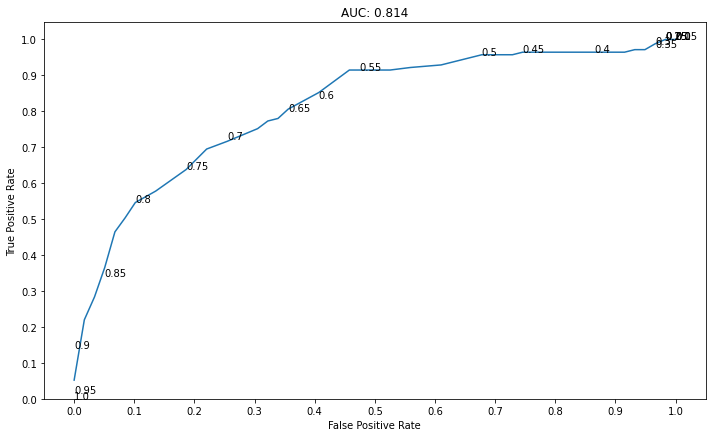

In [96]:
evaluator.plot_auc_curve()
plt.grid()

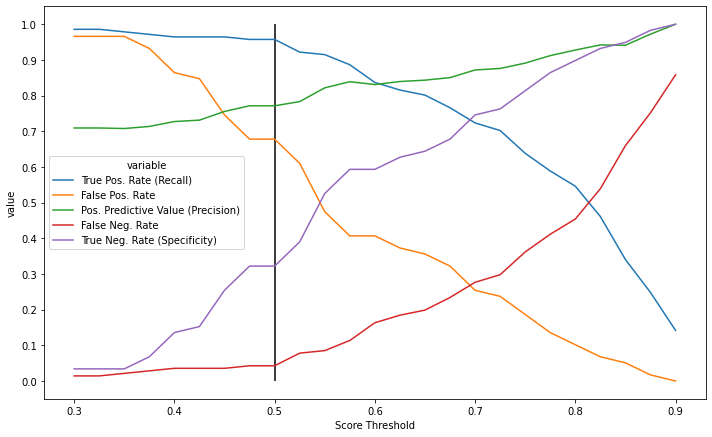

In [49]:
evaluator.plot_threshold_curves()
plt.grid()

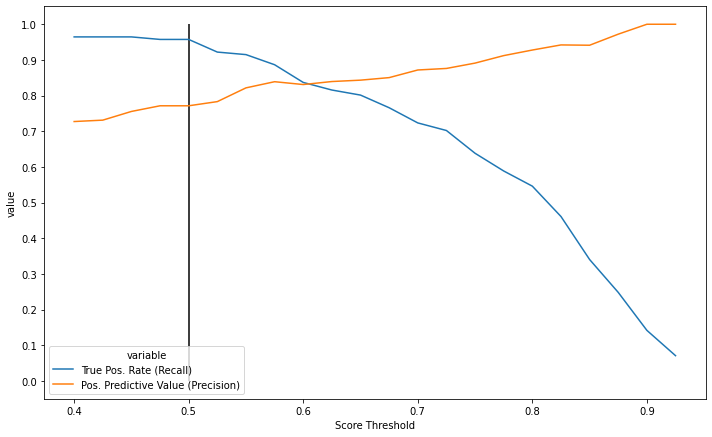

In [50]:
evaluator.plot_precision_recall_tradeoff(score_threshold_range=(0.4, 0.95))
plt.grid()

In [51]:
evaluator.calculate_lift_gain(return_style=True, include_all_info=True)

,# of Obs.,# of Pos. Events,Cumul. Pos. Events,Gain,Lift
Percentile,,,,,
5,10,10,10,0.07,1.42
10,10,10,20,0.14,1.42
15,10,9,29,0.21,1.37
20,10,9,38,0.27,1.35
25,10,9,47,0.33,1.33
30,10,10,57,0.40,1.35
35,10,9,66,0.47,1.34
40,10,8,74,0.52,1.31
45,10,8,82,0.58,1.29


In [52]:
del predicted_scores

# Feature Importance

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

In [53]:
from sklearn.inspection import permutation_importance
import time

estimator = full_pipeline

start_time = time.time()
result = permutation_importance(
    estimator, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

feature_names = X_train.columns.to_list()
forest_importances = pd.Series(result.importances_mean, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False)

Elapsed time to compute the importances: 4.504 seconds


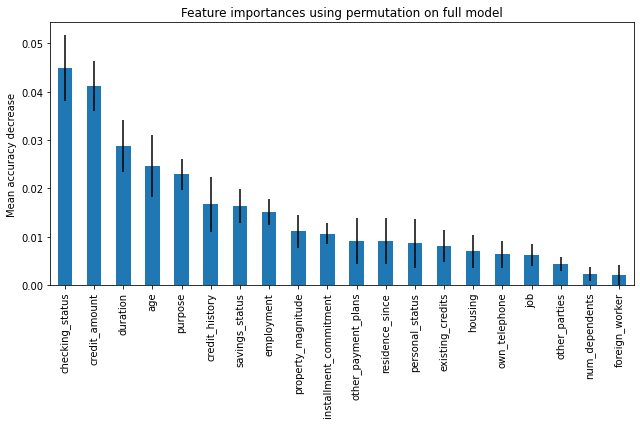

In [54]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.set_size_inches(9, 6)
fig.tight_layout()
plt.show()